## Load and preproceess the data

In [ ]:
import pandas as pd
import numpy as np

# Custom normalization function
def custom_normalize(df, feature_ranges):
    """
    Normalize specified columns according to given [min, max] ranges.
    
    :param df: Original DataFrame
    :param feature_ranges: Dictionary format, e.g. {'x1': (580, 680), 'x2': (220, 300)}
    :return: Normalized DataFrame
    """
    normalized_df = df.copy()
    for col, (min_val, max_val) in feature_ranges.items():
        normalized_df[col] = (df[col] - min_val) / (max_val - min_val)
    return normalized_df

# Load data from Excel file
data = pd.read_excel('Initial_data.xlsx', sheet_name='bayes-01')

# Define input features and target column
features = ['x1', 'x2', 'x3', 'x4', 'x5']
target_col = 'y1'

# Split features and target variable
X = data[features]
y = data[target_col]

# Apply custom normalization based on specified ranges
feature_ranges = {
    'x1': (580, 680),
    'x2': (220, 300),
    'x3': (0.025, 0.15),
    'x4': (0.01, 0.04),
    'x5': (0.0, 1.0)  # Example: assuming x5 range is [0, 1]
}

X = custom_normalize(X, feature_ranges)

# Define feature names for later use (e.g., model interpretation or visualization)
feature_names = ['x1', 'x2', 'x3', 'x4', 'x5']

In [80]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Function to train and evaluate the model using repeated cross-validation
def train_evaluate_model(model, model_name, X, y, num_repeats=5, num_folds=5):
    """
    Trains and evaluates a model using repeated K-Fold cross-validation.
    
    :param model: Model object (e.g., from scikit-learn)
    :param model_name: Name of the model (string)
    :param X: Feature data
    :param y: Target variable
    :param num_repeats: Number of repetitions for cross-validation
    :param num_folds: Number of folds per repetition
    :return: Dictionary containing evaluation metrics
    """
    
    # Initialize lists to store results
    all_r2_train = []
    all_rmse_train = []
    all_mae_train = []
    all_r2_test = []
    all_rmse_test = []
    all_mae_test = []

    all_y_train = []
    all_y_train_pred = []
    all_y_test = []
    all_y_test_pred = []
    all_x_train = []
    all_x_test = []

    # Perform repeated cross-validation
    for i in range(num_repeats):
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=i)
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Store results
            all_y_train.append(y_train)
            all_y_train_pred.append(y_train_pred)
            all_y_test.append(y_test)
            all_y_test_pred.append(y_test_pred)
            all_x_train.append(X_train)
            all_x_test.append(X_test)

            # Calculate evaluation metrics
            all_r2_train.append(r2_score(y_train, y_train_pred))
            all_rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            all_mae_train.append(mean_absolute_error(y_train, y_train_pred))

            all_r2_test.append(r2_score(y_test, y_test_pred))
            all_rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            all_mae_test.append(mean_absolute_error(y_test, y_test_pred))

    # Concatenate all true and predicted values
    y_train_combined = np.concatenate(all_y_train)
    y_train_pred_combined = np.concatenate(all_y_train_pred)
    y_test_combined = np.concatenate(all_y_test)
    y_test_pred_combined = np.concatenate(all_y_test_pred)

    x_train_combined = np.concatenate(all_x_train)
    x_test_combined = np.concatenate(all_x_test)

    # Compute mean and standard deviation of metrics
    metrics = {
        'model_name': model_name,
        'train_r2_mean': np.mean(all_r2_train),
        'train_r2_std': np.std(all_r2_train),
        'train_rmse_mean': np.mean(all_rmse_train),
        'train_rmse_std': np.std(all_rmse_train),
        'train_mae_mean': np.mean(all_mae_train),
        'train_mae_std': np.std(all_mae_train),

        'test_r2_mean': np.mean(all_r2_test),
        'test_r2_std': np.std(all_r2_test),
        'test_rmse_mean': np.mean(all_rmse_test),
        'test_rmse_std': np.std(all_rmse_test),
        'test_mae_mean': np.mean(all_mae_test),
        'test_mae_std': np.std(all_mae_test),
    }

    # Print performance summary
    print(f"\n=== {model_name} Performance ===")
    print(f"Train R² Mean: {metrics['train_r2_mean']:.4f}, Std: {metrics['train_r2_std']:.4f}")
    print(f"Train RMSE Mean: {metrics['train_rmse_mean']:.4f}, Std: {metrics['train_rmse_std']:.4f}")
    print(f"Train MAE Mean: {metrics['train_mae_mean']:.4f}, Std: {metrics['train_mae_std']:.4f}")
    print(f"Test R² Mean: {metrics['test_r2_mean']:.4f}, Std: {metrics['test_r2_std']:.4f}")
    print(f"Test RMSE Mean: {metrics['test_rmse_mean']:.4f}, Std: {metrics['test_rmse_std']:.4f}")
    print(f"Test MAE Mean: {metrics['test_mae_mean']:.4f}, Std: {metrics['test_mae_std']:.4f}")

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_combined, y_train_pred_combined, color='blue', label='Training Set', alpha=0.6)
    plt.scatter(y_test_combined, y_test_pred_combined, color='red', label='Test Set', alpha=0.6)
    plt.plot([y_train_combined.min(), y_train_combined.max()],
             [y_train_combined.min(), y_train_combined.max()],
             color='green', linestyle='--', label='Ideal Line')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save prediction results into DataFrames
    train_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_train_combined],
        'True_Y': y_train_combined,
        'Predicted_Y': y_train_pred_combined
    })

    test_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_test_combined],
        'True_Y': y_test_combined,
        'Predicted_Y': y_test_pred_combined
    })

    # Export to Excel with model name included in filename
    train_data.to_excel(f'train_predictions_{model_name}.xlsx', index=False)
    test_data.to_excel(f'test_predictions_{model_name}.xlsx', index=False)

    return metrics


=== GPR Performance ===
Train R² Mean: 0.9746, Std: 0.0018
Train RMSE Mean: 0.0203, Std: 0.0012
Train MAE Mean: 0.0165, Std: 0.0011
Test R² Mean: 0.4491, Std: 0.1850
Test RMSE Mean: 0.0884, Std: 0.0263
Test MAE Mean: 0.0629, Std: 0.0186


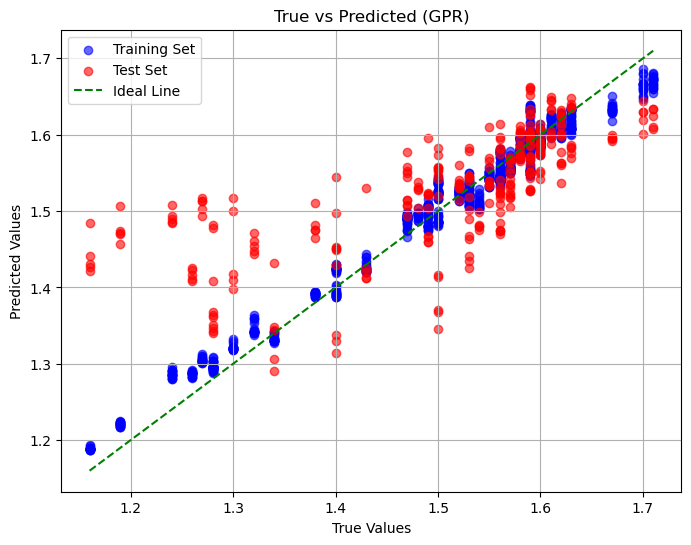

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Define the machine learning model
kernel = Matern(length_scale=1.0, nu=1.5) 
gpr = GaussianProcessRegressor(
    kernel=kernel,                     
    alpha=0.1,                        
    n_restarts_optimizer=20,          
    normalize_y=True                   
)

# Training and evaluation of the machine learning model
gpr_metrics = train_evaluate_model(gpr, "GPR", X, y, num_repeats=5, num_folds=5)


=== SVR Performance ===
Train R² Mean: 0.9761, Std: 0.0043
Train RMSE Mean: 0.0196, Std: 0.0012
Train MAE Mean: 0.0147, Std: 0.0008
Test R² Mean: 0.5891, Std: 0.1970
Test RMSE Mean: 0.0733, Std: 0.0160
Test MAE Mean: 0.0542, Std: 0.0115


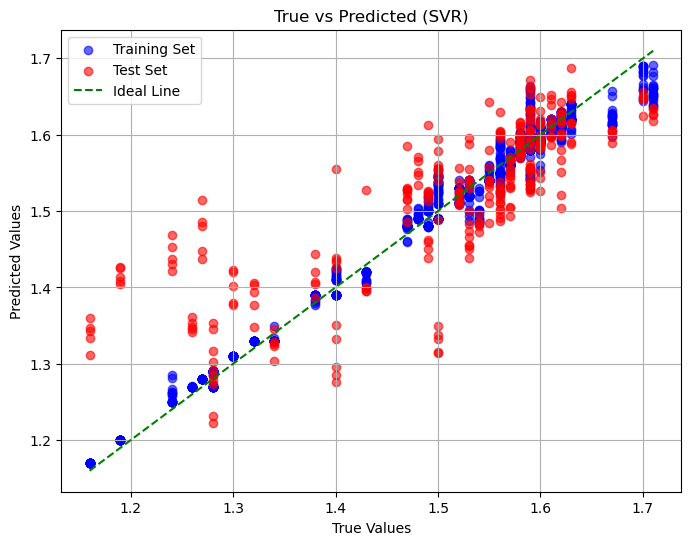

In [ ]:
from sklearn.svm import SVR  
svr = SVR(kernel='rbf', C=1, epsilon=0.01,)
SVR_metrics = train_evaluate_model(svr, "SVR", X, y, num_repeats=5, num_folds=5)


=== mlp Performance ===
Train R² Mean: 0.9012, Std: 0.0206
Train RMSE Mean: 0.0397, Std: 0.0030
Train MAE Mean: 0.0304, Std: 0.0026
Test R² Mean: 0.2834, Std: 0.4876
Test RMSE Mean: 0.0948, Std: 0.0308
Test MAE Mean: 0.0677, Std: 0.0229


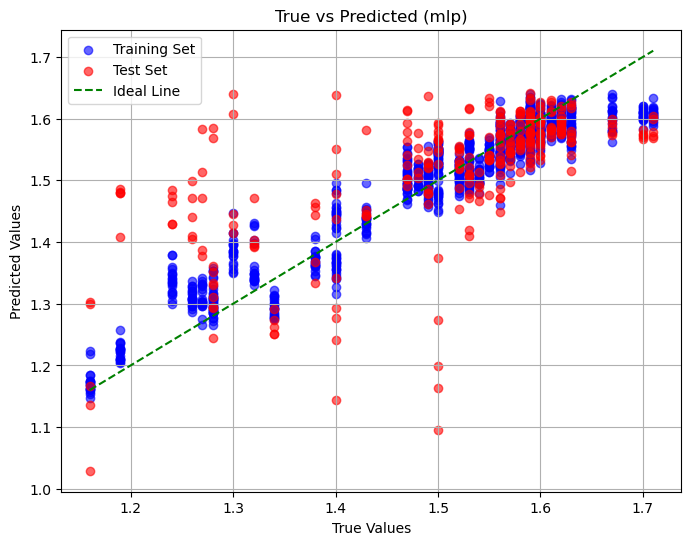

In [12]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=42, learning_rate_init = 0.01, learning_rate='adaptive',
             hidden_layer_sizes=(200, 400), alpha=0.05, activation='relu', max_iter=500)
mlp_metrics = train_evaluate_model(mlp, "mlp", X, y, num_repeats=5, num_folds=5)


=== dt Performance ===
Train R² Mean: 0.9231, Std: 0.0218
Train RMSE Mean: 0.0350, Std: 0.0046
Train MAE Mean: 0.0271, Std: 0.0030
Test R² Mean: 0.6689, Std: 0.3433
Test RMSE Mean: 0.0605, Std: 0.0267
Test MAE Mean: 0.0447, Std: 0.0174


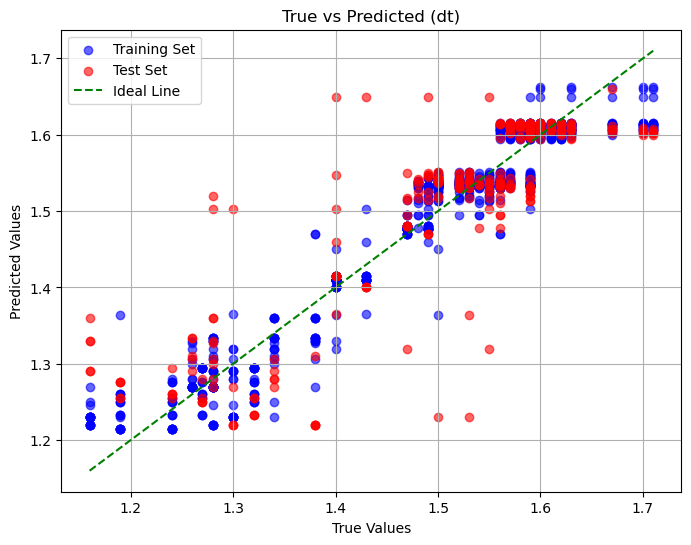

In [13]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=2, min_samples_split=2)
dt = train_evaluate_model(dt, "dt", X, y, num_repeats=5, num_folds=5)


=== RF Performance ===
Train R² Mean: 0.8727, Std: 0.0216
Train RMSE Mean: 0.0452, Std: 0.0024
Train MAE Mean: 0.0333, Std: 0.0017
Test R² Mean: 0.6995, Std: 0.1811
Test RMSE Mean: 0.0625, Std: 0.0188
Test MAE Mean: 0.0468, Std: 0.0147


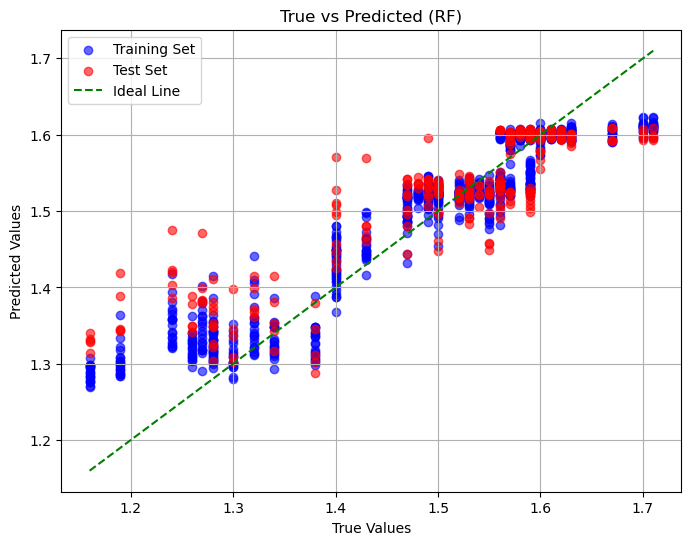

In [78]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(random_state=1, n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf= 2,max_leaf_nodes=5)
RF = train_evaluate_model(RF, "RF", X, y, num_repeats=5, num_folds=5)


=== xgb Performance ===
Train R² Mean: 0.9745, Std: 0.0106
Train RMSE Mean: 0.0199, Std: 0.0029
Train MAE Mean: 0.0151, Std: 0.0021
Test R² Mean: 0.7122, Std: 0.2139
Test RMSE Mean: 0.0595, Std: 0.0230
Test MAE Mean: 0.0455, Std: 0.0156


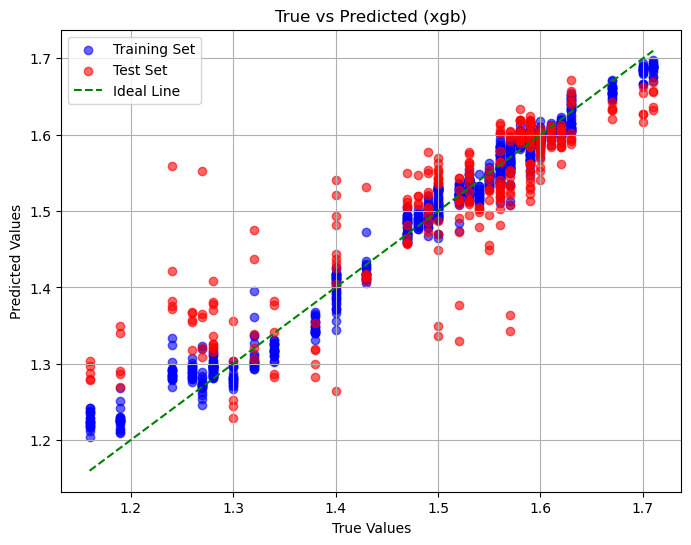

In [44]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=125, reg_lambda=10, reg_alpha=0,
                   min_child_weight=3, subsample=1, colsample_bytree=1.0)
xgb = train_evaluate_model(xgb, "xgb", X, y, num_repeats=5, num_folds=5)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

# Load data from Excel file
data = pd.read_excel('Total_data.xlsx')


X = data.iloc[:, :5]   
y = data.iloc[:, 5]    
feature_names = ['x1', 'x2', 'x3', 'x4', 'x5']

# Initialize XGBoost Regressor
xgb = XGBRegressor(
    max_depth=5,
    learning_rate=0.10,
    n_estimators=210,
    reg_lambda=5,
    reg_alpha=0.01,
    min_child_weight=3,
    subsample=1,
    colsample_bytree=0.8
)

# Define number of repeated cross-validation loops and folds
num_repeats = 5
num_folds = 5

# Initialize lists to store evaluation metrics
all_r2_train = []
all_rmse_train = []
all_mae_train = []
all_r2_test = []
all_rmse_test = []
all_mae_test = []
all_y_train = []
all_y_train_pred = []
all_y_test = []
all_y_test_pred = []
all_x_train = []
all_x_test = []

model_rf_results = []

# K-repeated K-Fold Cross Validator
for i in range(num_repeats):

    
    cv = KFold(n_splits=num_folds, shuffle=True, random_state=i)

    
    for train_index, test_index in cv.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = xgb.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)

        y_test_pred = model.predict(X_test)

        all_y_train.append(y_train)
        all_y_train_pred.append(y_train_pred)
        all_y_test.append(y_test)
        all_y_test_pred.append(y_test_pred)
        all_x_train.append(X_train)
        all_x_test.append(X_test)

        # Calculate evaluation metrics
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)

        all_r2_train.append(r2_train)
        all_rmse_train.append(rmse_train)
        all_mae_train.append(mae_train)
        all_r2_test.append(r2_test)
        all_rmse_test.append(rmse_test)
        all_mae_test.append(mae_test)

# Calculate mean and standard deviation of evaluation metrics
mean_r2_train = np.mean(all_r2_train)
std_r2_train = np.std(all_r2_train)
mean_rmse_train = np.mean(all_rmse_train)
std_rmse_train = np.std(all_rmse_train)
mean_mae_train = np.mean(all_mae_train)
std_mae_train = np.std(all_mae_train)

mean_r2_test = np.mean(all_r2_test)
std_r2_test = np.std(all_r2_test)
mean_rmse_test = np.mean(all_rmse_test)
std_rmse_test = np.std(all_rmse_test)
mean_mae_test = np.mean(all_mae_test)
std_mae_test = np.std(all_mae_test)

print("\nTraining Set - R2 Score", mean_r2_train)
print("Training Set - std R2 Score", std_r2_train)
print("Training Set - RMSE", mean_rmse_train)
print("Training Set - std RMSE Score", std_rmse_train)
print("Training Set - MAE", mean_mae_train)
print("Training Set - std MAE Score", std_mae_train)
print("Test Set - R2 Score", mean_r2_test)
print("Test Set - std R2 Score", std_r2_test)
print("Test Set - RMSE", mean_rmse_test)
print("Test Set - std RMSE Score", std_rmse_test)
print("Test Set - MAE", mean_mae_test)
print("Test Set - std MAE Score", std_mae_test)


# Plot predicted vs true values
y_train_combined = np.concatenate(all_y_train)
y_train_pred_combined = np.concatenate(all_y_train_pred)
y_test_combined = np.concatenate(all_y_test)
y_test_pred_combined = np.concatenate(all_y_test_pred)
x_test_combined = np.concatenate(all_x_test)
x_train_combined = np.concatenate(all_x_train)
plt.scatter(y_train_combined, y_train_pred_combined, color='blue', label='Training Set')
plt.scatter(y_test_combined, y_test_pred_combined, color='red', label='Test Set')
plt.plot([min(y_train_combined), max(y_train_combined)], [min(y_train_combined), max(y_train_combined)], color='green', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()